In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import solve_ivp

In [5]:
# Default plot parameters
font = {'weight' : 'normal',
        'size'   : 20}

rc('font', **font)
legend_fs = 16

N = 5
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.gnuplot2(np.linspace(0,1,N)))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['image.cmap'] = 'inferno'

In [6]:
# Load data
etch_data = pd.read_excel(r'Raw_data\Fig2_ARDE_data.xlsx')

We suspect ARDE which implies that the instantaneous etch rate depends on the aspect ratio:

$R(a(t)) = \frac{dd(a(t))}{dt}$. 

The integral of which is important to predict the membrane thickness $t_m(t) = t_0 - d(t) = t_0 - \int d(t) dt$.  

For fixed etch time $\Delta t$ and variable $w_m$ and $w_b$, depth $d$ increases linearly with $w_m$ and $w_b$. 

For fixed $w_m$, fixed $\Delta t$ and variable $w_b$ (non-ideal relation between $w_m$ and $w_b$), the depth $d$ is always the same. Therefore, the variation in depth cannot depend directly on $w_b$.

There is no mechanism which should explain a direct dependence on $w_m$ other than through the aspect ratio $a = \frac{d}{w_m}$. The dependence on the aspect ratio appears linear for a given etch time $t$ (secant time). We assume that this dependence on the aspect ratio is constant in time: 

$\frac{dR(a(t))}{dt} = \frac{d^2 d(a) }{dt^2} = 0$


Thus, the measured ARDE secant line is coincident with the tangent time (instantaneous etch rate). As such, a different etch time would simply slide the resulting apparent etch rate down the measured line. The instantenous etch rate can then be obtained by fitting the ARDE linear relation:

$R(a(t)) = \frac{dd(a(t))}{dt} = R_0 (1 + \beta a(t)) = R_0 (1 + \beta \frac{d(t)}{w_m}) $

From this expression, we can solve for $d(t)$
<!-- $ \frac{d}{dt}(d) =  R(\frac{d}{w_m}) = R_0 (1 + \beta \frac{d}{w_m})$ -->

$\Rightarrow  d(t) = C e^{\frac{R_0\beta}{w_m}t} - \frac{w_m}{\beta}  $

Apply initial condition $d(0)=0$:

$\Rightarrow  d(t) = \frac{w_m}{\beta} (e^{\frac{R_0\beta}{w_m}t} - 1)  $


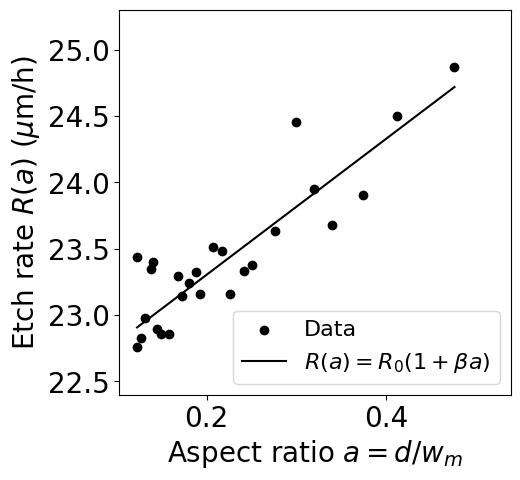

In [7]:
depth = etch_data['Depth ']                             # Etch depth (um)
aspect_ratio = depth / etch_data['H_surface']           # (depth / width) 
etch_time = 5.5                                         # (hours)
etch_rate = depth / etch_time                           # Apparent etch rate (um/h)

# Linear fit to extract $R_0$ and $\beta$
p_ARDE, cov = np.polyfit(aspect_ratio[4:-1], etch_rate[4:-1], 1, cov=True)
x_fit = aspect_ratio[4:-1]   # Discard points for which etch terminated at intersection of (111) planes
y_fit = np.polyval(p_ARDE,x_fit)
R_0 = p_ARDE[1]                                         # Etch rate at unetched surface (um/h)
beta = p_ARDE[0]/p_ARDE[1]                              # Dimensionless change in etch rate with aspect ratio

fig_ARDE, ax_ARDE = plt.subplots(figsize=(5.05,5))
ax_ARDE.scatter(aspect_ratio, etch_rate)
ax_ARDE.set_xlabel(r'Aspect ratio $a=d / w_m$')
ax_ARDE.set_ylabel(r'Etch rate $R(a)$ ($\mu$m/h)')
ax_ARDE.set_ylim([22.4,25.3])
ax_ARDE.plot(x_fit, y_fit, 'k')
ax_ARDE.legend(['Data', r'$R(a)=R_0 (1+\beta a)$'], loc='lower right', fontsize=legend_fs)


$ t_{\text{etch}} = \frac{w_m}{R_0 \beta} \ln{((\frac{\beta}{w_m} (t_{\text{initial}}-d_{\text{etch}}))+1)}$

$R(x,a(t)) = R_{0}e^{\gamma x}(1 + \beta a(t))$ 

$\gamma = \frac{1}{x_{lg}} \ln{\frac{R_{30}}{R_0}}$

Given that $x(d(t)) = \frac{x_{lg}}{t_{lg}} d(t)$: 

$R(x(t),a(t)) = \frac{dd(t)}{dt} = R_{0}e^{\frac{\gamma x_{lg}}{t_{lg}}d(t)}(1 + \beta a(t))$ 

In [8]:
# Model functions

def ARDE(t, w_m, beta, R_0):
    """ 
    Calculates the depth in the presense of aspect ratio dependent effects (ARDE) in pure silicon.
    
    Arguments: 
        t :     etch time (h)
        w_m :   mask width (um)
        beta :  dimensionless change in etch rate with aspect ratio
        R_0 :   etch rate at 0 aspect ratio (um/h)

    Returns: 
        d :     etch depth after etch time t (um)
    """
    d = (w_m/beta) * (np.exp(R_0*beta*t / w_m) - 1)         # Analytical solution
    return d 

def ARDE_inv(d, t_initial, w_m, beta, R_0):
    """ 
    Calculates the etch time in the presense of aspect ratio dependent effects (ARDE) in pure silicon 
    for a given input depth.
    
    Arguments: 
        d :         etch depth (um)
        t_initial : initial membrane thickness (um)
        w_m :       mask width (um)
        beta :      dimensionless change in etch rate with aspect ratio
        R_0 :       etch rate at 0 aspect ratio (um/h)

    Returns: 
        t_etch :    corresponding etch time (um)
    """
    t_etch = w_m/(R_0*beta) * np.log((beta/w_m)*(t_initial-d)+1)    # Analytical solution
    return t_etch


def graded_etch(t, w_m, beta, R_0, R_30, t_lg, x_lg=0.3):
    """ 
    Calculates the etch time in the presense of aspect ratio dependent effects (ARDE) in Si_{1-x}Ge_{x}.
    
    Arguments: 
        t :     etch time (h)
        w_m :   mask width (um)
        beta :  dimensionless change in etch rate with aspect ratio
        R_0 :   etch rate at 0 aspect ratio in pure silicon (um/h)
        R_30 :  etch rate at 0 aspect ratio in Si70Ge30 (um/h)
        t_lg :  Si_{1-x}Ge_{x} linearly graded buffer thicknes (um)
        x_lg :  germanium concentration of Si_{1-x}Ge_{x} constant composition buffer ([0,1])

    Returns: 
        t_etch :    corresponding etch time (um)
    """
    gamma = (1/x_lg) * np.log(R_30/R_0)
    R = lambda t, D: R_0 * np.exp(gamma*x_lg*D/t_lg) * (1+beta*D/w_m)
    
    sol = solve_ivp(R, [0, 100], [0], t_eval=[t])       # Numerical solution

    return sol.y[0][0]
    
    

In [9]:
class MuMem():
    """
    The MuMem class allows one to handle the etching dynamics of a Si/SiGe heterostructure, including graded layers.
    """

    def __init__(self, t_sub, t_lg, t_cc, w_m):
        self.t_sub = t_sub                      # Si handle wafer thickness (um)
        self.t_lg = t_lg                        # Si_{1-x}Ge_{x} linearly graded buffer thickness (um)
        self.t_cc = t_cc                        # Si70Ge30 constant composition buffer thickness (um)
        self.t_0 = [t_sub, t_lg, t_cc]          # Store initial thicknesses 
        self.w_b = w_m                          # Membrane base width (um) 
        self.w_m = w_m                          # Etch mask width (um)
        self.time_evol = [[],[],[]]             # Time steps for each layer 
        self.w_b_evol = [[],[],[]]              # Base width steps for each layer
        self.d_evol = [[],[],[]]                # Etch depth steps for each layer
        self.Si_angle = np.deg2rad(53.68)       # Sidewall angle in pure silicon
        self.Si70Ge30_angle = np.deg2rad(35)    # Sidewall angle in Si70Ge30

    def get_w_b_function(self, layer_idx):
        """ 
        Returns the function which calculates the base width depending on the layer index (layer_idx). 
        
        layer_idx: (0) Si handle wafer; (1) Si_{1-x}Ge_{x} linearly graded buffer, (2) Si70Ge30 constant composition buffer
        D: total etched depth (um)
        """
        
        t_lg_0 = self.t_0[1]

        if layer_idx == 0:
            # Constant sidewall angle in silicon
            base_width = lambda D : self.w_b - 2*D / np.tan(self.Si_angle) 

        elif layer_idx == 1:
            # Interpolated (exponential) sidewall angle in Si_{1-x}Ge_{x}
            base_width = lambda D : self.w_b - 2*D / np.tan(
                self.Si_angle - (self.Si_angle - self.Si70Ge30_angle) * (D / t_lg_0))
        
        elif layer_idx == 2:
            # Constant sidewall angle in Si70Ge30
            base_width = lambda D : self.w_b - 2*D / np.tan(self.Si70Ge30_angle)

        return base_width

    def etch(self, t_etch, dt, beta, R_0):
        """
        Etches the heterostructure from the back-side (starting with the Si handle wafer)

        Arguments: 
            t_etch :    Etch time (h)
            dt :        Time step (h)
            beta :  dimensionless change in etch rate with aspect ratio
            R_0 :   etch rate at 0 aspect ratio in pure silicon (um/h)      
        """
        self.beta = beta 
        self.R_0 = R_0
        t_initial = np.sum(self.t_0)

        # Etch substrate (t_sub) 
        t_etch_sub = ARDE_inv(0, self.t_sub, self.w_m, self.beta, self.R_0)
        w_b_fun = self.get_w_b_function(layer_idx=0)

        if t_etch_sub >= t_etch: # Incomplete substrate etch (t_m <= t_sub)
            time_sub_evol = np.arange(0, t_etch, dt)
            self.time_evol[0] = time_sub_evol
            self.d_evol[0] = ARDE(time_sub_evol, self.w_m, self.beta, self.R_0)
            self.t_m = t_initial - self.d_evol[0][-1] 
            self.w_b_evol[0] = w_b_fun(self.d_evol[0])
            self.w_b = self.w_b_evol[0][-1]
        else:  # Complete substrate etch (t_m > t_sub)
            time_sub_evol = np.arange(0, t_etch_sub, dt)
            self.time_evol[0] = time_sub_evol
            self.d_evol[0] = ARDE(time_sub_evol, self.w_m, self.beta, self.R_0)
            self.t_m = t_initial - self.d_evol[0][-1]
            self.w_b_evol[0] = w_b_fun(self.d_evol[0])
            self.w_b = self.w_b_evol[0][-1]

            # Etch linearly graded buffer (t_lg)
            t_remaining = t_etch - t_etch_sub
            d_test = graded_etch(t=t_remaining, w_m=self.w_m, beta=self.beta, R_0=self.R_0, R_30=0.3, t_lg=self.t_lg, x_lg=0.3)
            w_b_fun = self.get_w_b_function(layer_idx=1)
            
            if d_test <= self.t_lg: # Incomplete graded buffer etch (t_m <= (t_sub + t_lg))
                time_sub_evol = np.arange(0, t_remaining, dt)
                self.time_evol[1] = time_sub_evol + t_etch_sub
                d_lg = [
                    graded_etch(t=t, w_m=self.w_m, beta=self.beta, R_0=self.R_0, R_30=0.3, t_lg=self.t_lg, x_lg=0.3) for t in time_sub_evol
                ]
                self.d_evol[1] = self.d_evol[0][-1] + d_lg 
                self.t_m = t_initial - self.d_evol[1][-1]
                self.w_b_evol[1] = w_b_fun(np.array(d_lg))
                self.w_b = self.w_b_evol[1][-1]
            else:   # Complete graded buffer etch (t_m > (t_sub + t_lg))
                time_sub_evol = np.arange(t_etch_sub, t_etch, dt)

        

    def plot_etch_evolution(self, fig=None, ax=None, axins=None,  
                            plot_color='k', plot_label=None):
        if fig == None or ax[0] == None : 
            fig, ax = plt.subplots(1,2, figsize=(11.1,5))
        """
        Plots the membrane thickness (t_m) and membrane base width (w_b) as a function of etch time 
        """

        plt.subplot(121)
        t_initial = np.sum(self.t_0)
        naive_etch_rate = self.R_0
        total_time = np.concatenate([self.time_evol[0], self.time_evol[1], self.time_evol[2]])
        total_w_b = np.concatenate([self.w_b_evol[0], self.w_b_evol[1], self.w_b_evol[2]])
        total_D = np.concatenate([self.d_evol[0], self.d_evol[1], self.d_evol[2]])
        
        plt.plot(total_time, t_initial - total_D, color=plot_color, label=plot_label)
 
        plt.plot(total_time, 
                 t_initial - naive_etch_rate*np.array(total_time), 
                 color=plot_color, alpha=0.5, label=None)
  
        total_time_left = np.max(total_time) - total_time 
        
        if axins == None: 
            axins = inset_axes(ax[0], width="40%", height="30%", loc='upper right')
        axins.plot(60*total_time_left, t_initial - total_D, color=plot_color)
        axins.plot(60*total_time_left, t_initial - naive_etch_rate*np.array(total_time), color=plot_color, alpha=0.5)
        markers = ['o', 's', 'o']
        for ii in range(3):
            if len(self.time_evol[ii]) > 1:
                x = self.time_evol[ii][-1]
                y = self.d_evol[ii][-1]
            else:
                x = self.time_evol[ii]
                y = self.d_evol[ii]
                marker=None
            
            axins.scatter(60 * (np.max(total_time) - x), t_initial - y, s=20, 
                          marker=markers[ii],
                          color=plot_color, label=None)

        plt.subplot(122)
        w_initial = self.w_m
        plt.plot(total_time, 
                 w_initial - 2*naive_etch_rate*np.array(total_time)/np.tan(np.deg2rad(54.7)), 
                 color=plot_color, alpha=0.5, label=None)

        plt.plot(total_time, total_w_b, color=plot_color, label=None)

        fig.tight_layout(w_pad=0.3) 
        return fig, ax, axins

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_5672\3863789952.py:31: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('$t_m$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_5672\3863789952.py:33: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_ylabel('$w_b$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_5672\3863789952.py:35: SyntaxWarning: invalid escape sequence '\m'
  axins.set_ylabel('$t_m$ ($\mu$m)', fontsize=12)
C:\Users\lucas\AppData\Local\Temp\ipykernel_5672\921196910.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.3)
C:\Users\lucas\AppData\Loca

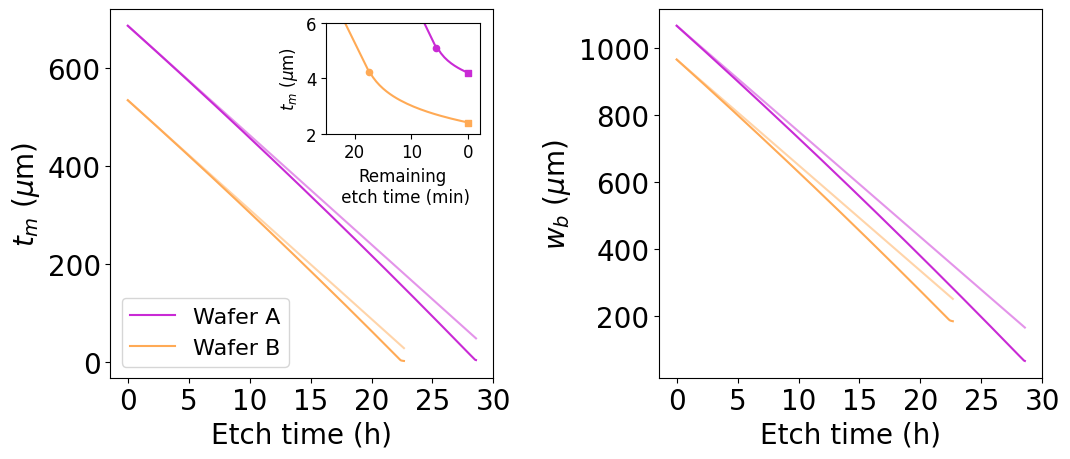

In [10]:
# Figure 2

# Wafer A
t0_waferA = 675 + 5.04           # Initial heterostructure thickness (handle wafer + grown Si/SiGe heterostructure)
w_m_waferA = 1055.9 + 10         # Nominal mask width + underetching by buffered oxide etch
waferA = MuMem(t_sub=t0_waferA, 
               t_lg=2.7, 
               t_cc=2.3, 
               w_m=w_m_waferA)
etch_time_waferA = 28 + 35/60
waferA.etch(t_etch=etch_time_waferA, dt=0.01, beta=beta, R_0=R_0)
fig, ax, axins = waferA.plot_etch_evolution(plot_color=color_cycle[2], plot_label='Wafer A')

# Wafer B
t0_waferB = 525 + 0.5+3.7         # Initial heterostructure thickness (handle wafer + grown Si/SiGe heterostructure)
w_m_waferB = 955 + 10             # Nominal mask width + underetching by buffered oxide etch
waferB = MuMem(t_sub=t0_waferB, 
               t_lg=3.7, 
               t_cc=0.5, 
               w_m=w_m_waferB)
etch_time_waferB = 22 + 40/60
waferB.etch(t_etch=etch_time_waferB, dt=0.01, beta=beta, R_0=R_0)
fig, ax, axins = waferB.plot_etch_evolution(fig=fig, ax=ax, axins=axins, 
                                           plot_color=color_cycle[3], plot_label='Wafer B')


ax[0].legend(loc='lower left', fontsize=legend_fs)
ax[0].set_xticks(np.arange(0,35,5), np.arange(0,35,5))
ax[1].set_xticks(np.arange(0,35,5), np.arange(0,35,5))
ax[0].set_xlabel('Etch time (h)')
ax[0].set_ylabel('$t_m$ ($\mu$m)')
ax[1].set_xlabel('Etch time (h)')
ax[1].set_ylabel('$w_b$ ($\mu$m)')
axins.set_xlabel('Remaining\n etch time (min)', fontsize=12)
axins.set_ylabel('$t_m$ ($\mu$m)', fontsize=12)
axins.tick_params(axis='both', labelsize=12) 
axins.set_xlim([-2,25])
axins.set_ylim([2,6])
axins.invert_xaxis()

predicted_geometry = [[waferA.t_m, waferA.w_b], [waferB.t_m, waferB.w_b]]
np.savetxt(r'predicted_geometry.txt', predicted_geometry)

fig.tight_layout()


<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_5672\426253850.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax_etch[0].set_xlabel('$w_m$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_5672\426253850.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax_etch[0].set_ylabel('$w_b^x$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_5672\426253850.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax_etch[1].set_xlabel('$w_m$ ($\mu$m)')


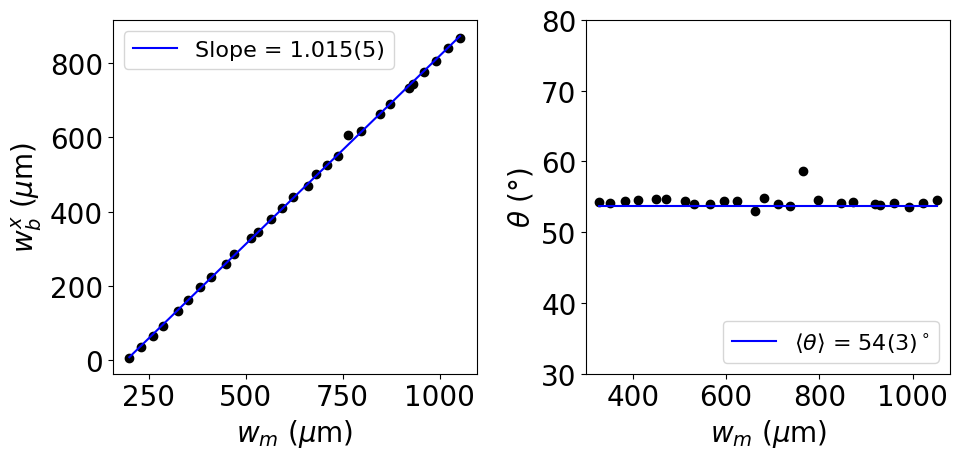

In [11]:
# Figure 8
fig_etch, ax_etch = plt.subplots(1,2, figsize=(10,5))

base_width = etch_data['H_base']
mask_width = etch_data['H_surface']

sidewall_angle = np.rad2deg(np.arctan(depth / ((mask_width - base_width)/2)))

p, cov = np.polyfit(mask_width[1:], base_width[1:], 1, cov=True)
x_fit = mask_width[1:]
y_fit = np.polyval(p,x_fit)


ax_etch[0].scatter(mask_width, base_width, label=None, color='k')
ax_etch[0].plot(x_fit, y_fit, color='b', label=rf'Slope = {p[0]:.3f}({1e3*np.sqrt(cov[0,0]):.1g})')
ax_etch[0].set_xlabel('$w_m$ ($\mu$m)')
ax_etch[0].set_ylabel('$w_b^x$ ($\mu$m)')
ax_etch[0].legend(loc='best', fontsize=legend_fs)

ax_etch[1].scatter(mask_width, sidewall_angle, label=None, color='k')
ax_etch[1].plot(mask_width[5:], np.mean(sidewall_angle) * np.ones((len(mask_width[5:]),)), color='b', 
                  label=rf'$\langle \theta \rangle$ = {np.mean(sidewall_angle):.0f}({np.std(sidewall_angle):.1g})$^\circ$')
ax_etch[1].set_xlabel('$w_m$ ($\mu$m)')
ax_etch[1].set_ylabel('$\\theta$ (°)')
ax_etch[1].legend(loc='lower right', fontsize=legend_fs)
ax_etch[1].set_xlim([300,1080])
ax_etch[1].set_ylim([30,80])

fig_etch.tight_layout()
